<a href="https://colab.research.google.com/github/alexncoleman/Wildfire-reinforcement-learning/blob/main/Wildfire_DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import math
import random
import copy
import random
#from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib import animation as animation

from PIL import Image, ImageSequence
import matplotlib as mpl

import os
import random



In [2]:

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
##################################################################
#test with real map
#forest = Image.open('drive/MyDrive/CA/land_data/BigChimney_canopy.tif')

#ignition = np.loadtxt('drive/MyDrive/CA/land_data/Brattain_2020_ignition_forest.txt')

#altitude = Image.open('drive/MyDrive/CA/land_data/BigChimney_slope.tif')

#density = Image.open('drive/MyDrive/CA/land_data/BigChimney_density.tif')
###################################################################################


###################################################################################


#forest = Image.open('drive/MyDrive/CA/land_data/canopy_Ferguson_2018.tif')

#ignition = np.loadtxt('drive/MyDrive/CA/land_data/Ferguson_2018_ignition_forest.txt')

#altitude = Image.open('drive/MyDrive/CA/land_data/slope_Ferguson_2018.tif')

#fuel = Image.open('images/fuel_Ferguson_2018.tif')

#density = Image.open('drive/MyDrive/CA/land_data/density_Ferguson_2018.tif')


###################################################################################
#test with real map
forest = Image.open('drive/MyDrive/ML/CA/land_data/canopy_Chimney_2016.tif')

ignition = np.loadtxt('drive/MyDrive/ML/CA/land_data/Ferguson_2018_ignition_forest2.txt').astype(int)
np.save('drive/MyDrive/ML/CA/land_data/Ferguson_2018_ignition_forest2.npy', ignition)
ignition = np.load('drive/MyDrive/ML/CA/land_data/Ferguson_2018_ignition_forest2.npy', mmap_mode = 'r').astype(int)

altitude = Image.open('drive/MyDrive/ML/CA/land_data/slope_Chimney_2016.tif')

#fuel = Image.open('images/fuel_Ferguson_2018.tif')

density = Image.open('drive/MyDrive/ML/CA/land_data/density_Chimney_2016.tif')

###################################################################################
#test with real map
#forest = Image.open('drive/MyDrive/CA/land_data/canopy_JakeChimney_2016.tif')

#ignition = np.loadtxt('drive/MyDrive/CA/land_data/Chimney_2016_ignition_forest2.txt')

#altitude = Image.open('drive/MyDrive/CA/land_data/slope_JakeChimney_2016.tif')

#fuel = Image.open('images/fuel_Ferguson_2018.tif')

#density = Image.open('drive/MyDrive/CA/land_data/density_JakeChimney_2016.tif')

In [4]:
np.array(forest).shape

(899, 982)

In [5]:
#plt.imshow(np.array(forest))

In [6]:
# def random_ignition(dim_x,dim_y):
#  field = np.ones((dim_x,dim_y))*2
#  x = random.randint(300,dim_x-300)
#  y = random.randint(300,dim_y-300)
#  for i in range(x,x+10):
#    for j in range(y,y+10):
#      field[i,j] = 3
#  return field

def random_ignition(dim_x,dim_y):
    field = np.ones((dim_x,dim_y))*2
    x = random.randint(30,dim_x-30)
    y = random.randint(30,dim_y-30)
    for i in range(x,x+4):
        for j in range(y,y+4):
            field[i,j] = 3
    return field.astype(int)

def centre_ignition(dim_x,dim_y):
    field = np.ones((dim_x,dim_y))*2
    x = round(dim_x/2)
    y = round(dim_y/2)
    for i in range(x,x+3):
        for j in range(y,y+3):
            field[i,j] = 3
    return field.astype(int)

In [7]:
forest = np.array(forest)

altitude = np.round(np.array(altitude)/np.max(altitude), 3)

density = np.array(density)

density = np.round(density/np.max(density), 3)

forest[forest<-999.] = 0.

forest = forest/np.max(forest)


from PIL import Image
from skimage.transform import resize

forest = resize(forest, (128, 128))
altitude = resize(altitude, (128, 128))
density = resize(density, (128, 128))

density = np.round(density/np.max(density))

n_row = forest.shape[0]
n_col = forest.shape[1]

number_MC = 20
#################################################################
generation = 501
n_row = forest.shape[0]
n_col = forest.shape[1]

In [8]:
def colormap(i,array):
    np_array = np.array(array)
    plt.imshow(np_array, interpolation="none", cmap=cm.plasma)
    plt.title(i)
    plt.show()

In [9]:
def init_vegetation():
    veg_matrix = [[0 for col in range(n_col)] for row in range(n_row)]
    for i in range(n_row):
        for j in range(n_col):
            veg_matrix[i][j] = 1
    return veg_matrix

def init_density():
    den_matrix = [[0 for col in range(n_col)] for row in range(n_row)]
    for i in range(n_row):
        for j in range(n_col):
            den_matrix[i][j] = 1.0
    return den_matrix.astype(int)

def init_altitude():
    alt_matrix = [[0 for col in range(n_col)] for row in range(n_row)]
    for i in range(n_row):
        for j in range(n_col):
            alt_matrix[i][j] = 1
    return alt_matrix

def init_forest():
    forest = [[0 for col in range(n_col)] for row in range(n_row)]
    for i in range(n_row):
        for j in range(n_col):
            forest[i][j] = 2
    # ignite_col = int(n_col//2)
    # ignite_row = int(n_row//2)
    ignite_col = int(n_col//2)
    ignite_row = int(100)
    for row in range(ignite_row-1, ignite_row+1):
        for col in range(ignite_col-1,ignite_col+1):
            forest[row][col] = 3
    # forest[ignite_row-2:ignite_row+2][ignite_col-2:ignite_col+2] = 3
    return forest.astype(int)


In [10]:
def print_forest(forest):
    for i in range(n_row):
        for j in range(n_col):
            sys.stdout.write(str(forest[i][j]))
        sys.stdout.write("\n")

In [11]:
def tg(x):
    return math.degrees(math.atan(x))

In [12]:
def get_slope(altitude_matrix):
    slope_matrix = [[0 for col in range(n_col)] for row in range(n_row)]
    for row in range(n_row):
        for col in range(n_col):
            sub_slope_matrix = [[0,0,0],[0,0,0],[0,0,0]]
            if row == 0 or row == n_row-1 or col == 0 or col == n_col-1:  # margin is flat
                slope_matrix[row][col] = sub_slope_matrix
                continue
            current_altitude = altitude_matrix[row][col]
            sub_slope_matrix[0][0] = tg((current_altitude - altitude_matrix[row-1][col-1])/1.414)
            sub_slope_matrix[0][1] = tg(current_altitude - altitude_matrix[row-1][col])
            sub_slope_matrix[0][2] = tg((current_altitude - altitude_matrix[row-1][col+1])/1.414)
            sub_slope_matrix[1][0] = tg(current_altitude - altitude_matrix[row][col-1])
            sub_slope_matrix[1][1] = 0
            sub_slope_matrix[1][2] = tg(current_altitude - altitude_matrix[row][col+1])
            sub_slope_matrix[2][0] = tg((current_altitude - altitude_matrix[row+1][col-1])/1.414)
            sub_slope_matrix[2][1] = tg(current_altitude - altitude_matrix[row+1][col])
            sub_slope_matrix[2][2] = tg((current_altitude - altitude_matrix[row+1][col+1])/1.414)
            slope_matrix[row][col] = sub_slope_matrix
    return slope_matrix

In [13]:
def simulation(stage, per_bar_time, temp_bar_time, make_fig=False, forest_before_bar=None, whole_time=None, per_bar_input=None, temp_bar_input=None, max_per_len=None, max_temp_len=None):
    """
    input:
    stage = before bar:1, after bar:2
    bar_time = when is the bar was set
    bar_input = matrix of bar
    max_per_len = the maxmimum length of the permanent bar
    max_temp_len = the maxmimum length of the temporary bar

    output:
        stage1: the list of forest matrix before bar in time sequence
        stage2: loss
    """
    ###########################################################################
    #init

    ignition = random_ignition(np.array(forest).shape[0],np.array(forest).shape[1]).astype(int)
    #ignition = centre_ignition(np.array(forest).shape[0], np.array(forest).shape[1]).astype(int)

    #np.save('drive/MyDrive/CA/VAE/ignition/ignition_Brattain_'+str(index)+'.npy',ignition)

    V = 5. # need to find the true wind data
    p_h = 0.58
    a = 0.078
    c_1 = 0.045
    c_2 = 0.131

    ##############################################################################
    def calc_pw(theta,c_1,c_2,V):
        t = math.radians(theta)
        ft = math.exp(V*c_2*(math.cos(t)-1))
        return math.exp(c_1*V)*ft

    def count_3_and_4(matrix): #counting burned area
        count = 0
        for row in matrix:
            for element in row:
                if element == 3 or element == 4:
                    count += 1
        return count

    def get_wind():

      #wind_matrix = [[0 for col in [0,1,2]] for row in [0,1,2]]

      #thetas = [[0,180,180], #need to define the exact angle
      #          [180,0,180],
      #          [180,180,0]]

      #thetas = [[45,0,45], #need to define the exact angle
                #[90,0,90],
                #[135,180,135]]

      #for row in [0,1,2]:
          #for col in [0,1,2]:
              #wind_matrix[row][col] = calc_pw(thetas[row][col],c_1,c_2,V)
      #wind_matrix[1][1] = 0
        wind_matrix = [[1,0.5,0], #need to define the exact angle
                  [0.5,0,0],
                  [0,0,0]]
        return wind_matrix

    def burn_or_not_burn(abs_row, abs_col, neighbour_matrix, p_h,a): #removed p_bar = 0.1 from inputs
        p_veg = vegetation_matrix[abs_row][abs_col]
        p_den = {0:-0.4,1:0,2:0.3}[density_matrix[abs_row][abs_col]]
        for row in [0,1,2]:
            for col in [0,1,2]:
                if neighbour_matrix[row][col] == 3: # we only care there is a neighbour that is burning
                    # print(row,col)
                    slope = slope_matrix[abs_row][abs_col][row][col]
                    p_slope = math.exp(a * slope)
                    p_wind = wind_matrix[row][col]
                    p_burn = p_h * (0.5 + p_veg*10.) * (1 + p_den) * p_wind * p_slope
                    if p_burn > random.random():
                        return 3  #start burning
        return 2 # not burning

    def permanant_burn_or_not_burn(abs_row, abs_col, neighbour_matrix, p_h,a, p_bar=0.05): #determining if cells with barriers get burnt, assuming barriers have a burn probability of 0.05
        p_veg = vegetation_matrix[abs_row][abs_col]
        p_den = {0:-0.4,1:0,2:0.3}[density_matrix[abs_row][abs_col]]
        for row in [0,1,2]:
            for col in [0,1,2]:
                if neighbour_matrix[row][col] == 3:
                    slope = slope_matrix[abs_row][abs_col][row][col]
                    p_slope = math.exp(a * slope)
                    p_wind = wind_matrix[row][col]
                    p_burn = p_h * (0.5 + p_veg*10.) * (1 + p_den) * p_wind * p_slope * p_bar
                    if p_burn > random.random():
                        return 3  #start burning
        return 5 # not burning

    def update_forest(old_forest):
        result_forest = [[1 for i in range(n_col)] for j in range(n_row)]
        for row in range(1, n_row-1):
            for col in range(1, n_col-1):

                if old_forest[row][col] == 1 or old_forest[row][col] == 4 or old_forest[row][col] == 6:
                    result_forest[row][col] = old_forest[row][col]  # no fuel or burnt down or temporary bar

                if old_forest[row][col] == 3:
                    if random.random() < 0.4: #determining if cell is burnt or continues burning
                        result_forest[row][col] = 3  # TODO need to change back here
                    else:
                        result_forest[row][col] = 4

                if old_forest[row][col] == 2: #dealing with fuel cells
                    neighbours = [[row_vec[col_vec] for col_vec in range(col-1, col+2)]
                                    for row_vec in old_forest[row-1:row+2]]
                    # print(neighbours)
                    result_forest[row][col] = burn_or_not_burn(row, col, neighbours,p_h,a)

                if old_forest[row][col] == 5: #dealing with barrier cells and if they burn or not
                    neighbours = [[row_vec[col_vec] for col_vec in range(col-1, col+2)]
                                    for row_vec in old_forest[row-1:row+2]]
                    result_forest[row][col] = permanant_burn_or_not_burn(row, col, neighbours, p_h,a)

        return result_forest

    #check_bar_type
    def check_temp_bar_input(forest, temp_bar_input, max_temp_len):
        temp_count = 0
        new_forest = forest

        for row in temp_bar_input:
            for element in row:
                if element != 0 and element != 6:
                    raise TypeError("The temp bar input is wrong, should be either 0 or 6.")

                #check_bar_length
                if element == 6: #6 is temperorary barrier
                    temp_count += 1

        if  temp_count > max_temp_len:
            raise TypeError("The max length of temp bar is exceeded.")


    def check_per_bar_input(forest, per_bar_input, max_per_len):
        per_count = 0
        new_forest = forest

        for row in per_bar_input:
            for element in row:
                if element != 0 and element != 5 :
                    raise TypeError("The per bar input is wrong, should be either 0 or 5.")

                #check_bar_length
                if element == 5: #5 is permenant barrier
                    per_count += 1

        if per_count > max_per_len :
            raise TypeError("The max length of per bar is exceed.")

        #check_permanent_dist, if the fire is burning within a 10x10 square of each of the barrier cells then barrier is too close, if barrier outside of 30x30 square then too far
        #for row in range(5, n_row-5):
        #    for col in range(5, n_col-5):
        #        if per_bar_input[row][col] == 5:
        #          neighbours_close = [[row_vec[col_vec] for col_vec in range(col-2, col+3)]
        #                    for row_vec in new_forest[row-2:row+3]]
        #          neighbours_far = [[row_vec[col_vec] for col_vec in range(col-20, col+21)]
        #                    for row_vec in new_forest[row-20:row+21]]

                  #if too close
                  #if any(3 in row for row in neighbours_close):
                  #  raise TypeError("The permenant bar is too close to the fire front.")

                  #if too far
                  #if any(3 in row for row in neighbours_far) == False:
                  #  raise TypeError("The permenant bar is too far from the fire front.")



    ###########################################################
    # custormize colorbar

    cmap = mpl.colors.ListedColormap(['orange', 'yellow', 'green', 'red', 'black', 'white', 'blue'])
    cmap.set_over('0.25')
    cmap.set_under('0.75')
    bounds = [1.0, 2.02, 2.27, 3.01, 3.5, 5.1, 5.9, 6.9]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    ############################################################
    #init
    fields_1_sim = np.zeros((1,100))

    vegetation_matrix = np.round(forest,3)

    density_matrix = np.round(density, 3).tolist()

    altitude_matrix = np.round(altitude,3).tolist()

    wind_matrix = get_wind()

    new_forest = ignition.tolist()


    slope_matrix = get_slope(altitude_matrix)

    ############################################################
    #the fire progress before set the bar
    if stage == 1:
        #############################################################################
        #init
        stage_1_forest_list = [np.array(new_forest)]

        #############################################################################
        #begin to loop
        bar_time = min(temp_bar_time, per_bar_time)

        for day in range(bar_time+1):
            #print(f'time step: {day}')
            new_forest = copy.deepcopy(update_forest(new_forest))
            forest_array = np.array(new_forest)
            stage_1_forest_list.append(forest_array)

            if day>0 and day%1 == 0 and day <= bar_time and make_fig:

                #np.save('drive/MyDrive/CA/VAE/ignition_Brattain_'+str(index)+'_'+str(i)+'_'+'.npy',forest_array)
                #np.save('drive/MyDrive/CA/VAE/ignition_Chimney_'+str(index)+'_'+str(i)+'_'+'.npy',forest_array)
                #np.save('drive/MyDrive/CA/Field/JChimney_'+str(index)+'_'+str(i)+'_'+'.npy',forest_array)

                plt.imshow(forest + forest_array,  cmap = cmap, norm = norm, interpolation="none" )
                plt.axis('off')
                plt.title(f'temp:{temp_bar_time}, per:{per_bar_time}, time step: {day}')

                # Create the directory if it doesn't exist, not saving fig
                #if not os.path.exists(directory):
                #    os.makedirs(directory)
                # Save the image with the desired file path
                #plt.savefig(directory + 'fire_' + str(day).zfill(3) + '.png', format='png', bbox_inches='tight')

                plt.show()
                plt.close()
                print('burning',np.sum(forest_array==3))
            plt.show()
            plt.close()
        return forest_array.astype(int), altitude_matrix, wind_matrix

    ############################################################
    #the fire progress after set the bar
    elif stage == 2:
        ############################################################################
        #init
        new_forest = copy.deepcopy(forest_before_bar)
        loss = count_3_and_4(new_forest)
        stage_2_forest_list = [np.array(new_forest)]


        #check overlap
        all_bar = per_bar_input + temp_bar_input
        if 11 in all_bar:
            raise TypeError("Two bar is overlaped")

        ############################################################################
        #update forest
        for day in range(min(temp_bar_time, per_bar_time), whole_time+1):
            #print(f'time step: {day}')

            if day == temp_bar_time:
                #check input
                check_temp_bar_input(new_forest, temp_bar_input, max_temp_len)
                forest_before_temp_bar =  copy.deepcopy(new_forest)
                #insert bar
                for i in range(n_row):
                    for j in range(n_col):
                        if temp_bar_input[i][j] != 0:
                            new_forest[i][j] = temp_bar_input[i][j]

            if day == per_bar_time:
                #check input
                check_per_bar_input(new_forest, per_bar_input, max_per_len)
                #insert bar
                for i in range(n_row):
                    for j in range(n_col):
                        if per_bar_input[i][j] != 0:
                            new_forest[i][j] = per_bar_input[i][j]

            if day == temp_bar_time + 4:
                for row in range(128):
                    for col in range(128):
                        if new_forest[row][col] == 6:
                            new_forest[row][col] = forest_before_temp_bar[row][col]

            new_forest = copy.deepcopy(update_forest(new_forest))
            forest_array = np.array(new_forest)
            stage_2_forest_list.append(forest_array)

            if day>0 and day%1 == 0 and make_fig:

                #np.save('drive/MyDrive/CA/VAE/ignition_Brattain_'+str(index)+'_'+str(i)+'_'+'.npy',forest_array)
                #np.save('drive/MyDrive/CA/VAE/ignition_Chimney_'+str(index)+'_'+str(i)+'_'+'.npy',forest_array)
                #np.save('drive/MyDrive/CA/Field/JChimney_'+str(index)+'_'+str(i)+'_'+'.npy',forest_array)

                plt.imshow(forest + forest_array,  cmap = cmap, norm = norm, interpolation="none" )
                plt.axis('off')
                plt.title(f'temp:{temp_bar_time}, per:{per_bar_time}, time step: {day}')

                #plt.savefig(directory + 'fire_' + str(day).zfill(3) +'.png', format='png',bbox_inches='tight')

                plt.show()
                plt.close()
                print('burning',np.sum(forest_array==3))

            plt.show()
            plt.close()

        burnt_area = np.sum(forest_array == 4) + np.sum(forest_array == 3)
        loss = count_3_and_4(new_forest) - loss
        return forest_array.astype(int), burnt_area, altitude_matrix, wind_matrix, stage_2_forest_list[1]

    else:
        raise TypeError('The stage should be either 1 or 2')

## Running the Simulation

In [14]:
#for now consider only permenant barriers

#obtaining a permenant barrier matrix, for a 10x3 permenant barrier
def fire_break(forest, x_pos, y_pos):
  fire_break = np.zeros(np.shape(forest))
  x = x_pos # x position of centre of fire break
  y = y_pos
  for i in range(x-1,x+2):
    for j in range(y-5,y+5):
      if i >= 128 or i <= 0 or j>=128 or j <= 0:
        try:
          fire_break[i-1,j+1] = 5
        except:
          fire_break[i-1, j-1] = 5
      else:
        fire_break[i,j] = 5
  return fire_break

#to ignore temporary barrier just create a zeros matrix
temp_firebreak = np.zeros(np.shape(forest))

#starting with a permenant barrrier in the centre
per_firebreak = fire_break(forest, 55, 55)

#simulating the wildfire
#current_forest, alt, wind = simulation(1, 3, 3, True)
#forest_history2, alt, wind, burnt_area = simulation(2, 3, 3, True, current_forest, 16, per_firebreak, temp_firebreak, 30, 0)
#per_firebreak = fire_break(forest, 75, 75)
#forest_history3, alt, wind, burnt_area = simulation(2, 3, 3, True, current_forest, 16, per_firebreak, temp_firebreak, 30, 0)
#print("loss: ", loss)
#print("Burnt area: ", burnt_area)


## Creating DQN





In [15]:
#Model, input is the 128x128 image of the forest fire.
import numpy as np
import tensorflow as tf
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import mean_squared_error
import os
import cv2
import shutil
import gc
bar_directory = r'/content/drive/MyDrive/ML/Bar Forests' #changing directory within google drive
emp_directory = r'/content/drive/MyDrive/ML/Emp Forests'
buffer_directory = r'/content/drive/MyDrive/ML/Buffer Forests'
filename = r"bar_input_forest index"
emp_filename = r"emp_input_forest index"

class DQN():
  def __init__(self, action_size, input_shape, summary = False): #assuming input has dimension (16,26,1)

    """
  forest (array) - forest array up to point at which fire breaks should be placed
  define some parameters and hyperparameters:
         "lr" : learning rate
         "gamma": discounted factor
         "exploration_proba_decay": decay of the exploration probability
         "batch_size": size of experiences we sample to train the DNN
    """
    self.input_row = input_shape[0]
    self.input_col = input_shape[1]

    #now forming DNN
    self._lr = 0.00028
    self._gamma = 0.99
    self._exploration_prob_decay = 0.03
    self._exploration_prob = 1
    self._batch_size = 32

    #now creating a memory buffer
    self.memory_buffer = {} #store as dictionary so that memorys can easily be replaced
    self.max_memory_buffer = 450

    #Now the DQN network
    self.model = Sequential()
    self.model.add(Conv2D(filters = 4, kernel_size = (3, 3), activation='relu',
    padding='same', input_shape = (self.input_row,self.input_col,4), data_format = "channels_last"))
    self.model.add(MaxPooling2D(pool_size = (2, 2), padding='same', input_shape = (16,16,4)))
    self.model.add(Flatten())
    #print(self.model.output_shape)
    self.model.add(Dense(units = 128, activation = 'relu', input_shape = (256,)))
    self.model.add(Dense(units = 64, activation = 'relu'))
    self.model.add(Dense(units = 64, activation = 'relu'))
    self.model.add(Dense(units = 2, activation = 'relu'))
    self.model.add(Dense(units = action_size, activation = 'linear'))


    self.model.compile(loss="mse",
                      optimizer = Adam(learning_rate = self._lr))
    if summary == True:
      self.model.summary()

  def burning_cells(self, forest, wind):
    """ This method is used to find the position of all of the burning cells for
    a given forest state
    forest (array) - forest state in question """
    self._burning_cells = []
    self._neighbour_coord = []
    self.burning_matrix = np.zeros(np.shape(forest))
    self.wind_matrix = np.zeros(np.shape(forest))
    self._too_close = []
    n_row = forest.shape[0]
    n_col = forest.shape[1]
    #getting the burning cells
    for row in range(1, n_row - 1):
      for col in range(1, n_col - 1):
        if forest[row][col] == 3:
          self._burning_cells.append((row, col))
          self.burning_matrix[row][col] == 1 #creating a matrix of 0s with 1s where the forest is burning
          for i in range(3):
            for j in range(3):
              self.wind_matrix[row+i][col+j] = wind[i][j]

          #creating a grid of cells that are too close to burning cells (within a 5x5 grid of burning cells)
          for  neighbour_col in range(col - 2, col + 3):
            for neighbour_row in range(row - 2, row + 3):
              if (neighbour_row, neighbour_col) not in self._too_close:
               self._too_close.append((neighbour_row, neighbour_col))

          #getting the neighbours of burning cells to get a neighbours matrix (all neighbours will be the 'agents')
          for neighbour_col in range(col-5, col+6):
            for neighbour_row in range(row - 5, row + 6):  #looking at 10x10 grid around each burning cell to get neighbour cells
              if (neighbour_row, neighbour_col) not in self._neighbour_coord\
              and (neighbour_row, neighbour_col) not in self._too_close\
              and forest[neighbour_row][neighbour_col] != 3\
              and forest[neighbour_row][neighbour_col] !=4: #so we only upload new cells and cells that aren't burning, burnt, and far enough away from the burning cells to the neighbour coord and matrix
                self._neighbour_coord.append((neighbour_row, neighbour_col))


  def choose_actions(self, forest, alt, wind, length_of_barrier):
    """
    forest (array) - forest array up to point at which fire breaks should be placed
    length_of_barrier (int) - number of cells that can be firebreaks

    """
    self.input_forest = np.zeros((1, self.input_row, self.input_col, 4)).astype(int) # 4 because there are 4 channels: input forest, altitude, wind, and burning cells
    self.bar_cells = []
    self.bar_Q_val = []
    self.bar_input_states = []
    self.emp_cells = []
    self.emp_Q_val = []
    self.emp_input_states = []
    self.length_of_barrier = length_of_barrier
    #randomly shufffle the neighbour cells
    np.random.shuffle(self._neighbour_coord)
    for cell in self._neighbour_coord:
      if random.random() <= self._exploration_prob: ##choosing a random action or not depending on episilon greedy function
        #need to obtain q val for later updates, so need to define the input forest
        x,y = cell
        #obtain input matrix
        for i in range(-8, 8):
          for j in range(-8, 8):
            if x+i > 128 or y+j > 128 or x+i < 0 or y+j < 0: #for when index is out of bounds
              self.input_forest[0][i][j][0] = 1 #as this is 'no fuel' cell
              self.input_forest[0][i][j][1] = 0 #as there should be 0 altitude
              self.input_forest[0][i][j][2] = 0 #as there is 0 wind effects
              self.input_forest[0][i][j][3] = 0 #as there are no burning cells out of bounds


            else:
              self.input_forest[0][i][j][0] = forest[i+x][j+y]/5 # / to normalise
              self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
              self.input_forest[0][i][j][2] = self.wind_matrix[i+x][j+y]/np.max(wind)
              self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]
        q_vals = self.model.predict(self.input_forest, verbose = 0) #divide self.input forest by 5 in order to normalise input image
        if random.choice([0,1]) == 0: #action 0 corresponds with cell being a firebreak
          if len(self.bar_cells) == self.length_of_barrier:
            #if max number of barrier cells already reached, just replace a random one. So choose a random index
            index = random.randint(0,29)
            #move the cells with lower barrier q val to the none barrier lists
            self.emp_Q_val.append(self.bar_Q_val[index])
            self.emp_cells.append(self.bar_cells[index])
            #self.emp_input_states.append(self.bar_input_states[index])
            shutil.move(bar_directory+"/"+self.bar_input_states[index], emp_directory+"/"+
                        emp_filename.replace("index", str(len(self.emp_input_states)))+".npy") #moving image into empty cell folder
            self.emp_input_states.append(self.bar_input_states[index].replace("bar_input_forest"+" "+str(index),
                                                                              "emp_input_forest"+" "+str(len(self.emp_input_states))))
            #update the barrier lists with the new cell
            os.chdir(bar_directory)
            np.save(filename.replace("index", str(index))+ ".npy", np.reshape(self.input_forest, (1,16,16,4))) #save image to filename in bar_directory
            self.bar_Q_val[index] = q_vals
            self.bar_cells[index] = cell
            self.bar_input_states[index] = filename.replace("index", str(index))+".npy"

          #if max number of barrier cells is not reached yet
          elif len(self.bar_Q_val) < self.length_of_barrier: #getting barrier of cells of the correct size
            os.chdir(bar_directory)
            np.save(filename.replace("index", str(len(self.bar_input_states)))
            + ".npy", np.reshape(self.input_forest, (1,16,16,4))) #save image to filename in bar_directory
            self.bar_input_states.append(filename.replace("index", str(len(self.bar_input_states)))+".npy")
            #self.bar_input_states.append(self.input_forest)
            self.bar_Q_val.append(q_vals)
            self.bar_cells.append(cell)


        else: #if choice is to make the cell a empty cell
          os.chdir(emp_directory)
          self.emp_Q_val.append(q_vals)
          self.emp_cells.append(cell)
          np.save(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy",
                      np.reshape(self.input_forest, (1,16,16,4))) #save image to filename in bar_directory
          self.emp_input_states.append(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy")

      #now for case where action is not random
      else:
        x,y = cell
        #obtain input matrix
        for i in range(-8, 8):
          for j in range(-8, 8):
            if x+i > 128 or y+j > 128 or x+i < 0 or y+j < 0:
              self.input_forest[0][i][j] = 1 #as this is 'no fuel' cell

            else:
              self.input_forest[0][i][j] = forest[i+x][j+y]
        q_vals = self.model.predict(self.input_forest/5, verbose = 0) #divide self.input forest by 5 in order to normalise input image
        if q_vals[0][0] > q_vals[0][1]: #i.e. if it is better for the cell to be a fire break than empty

          if len(self.bar_cells) == self.length_of_barrier:
            if q_vals[0][0] > np.min(np.array(self.bar_Q_val)[:,0,0]):
              index = np.argmin(np.array(self.bar_Q_val)[:,0,0])
              #move the cells with lower barrier q val to the none barrier lists
              self.emp_Q_val.append(self.bar_Q_val[index])
              self.emp_cells.append(self.bar_cells[index])
              shutil.move(bar_directory+"/"+filename.replace("index", str(index))+".npy", emp_directory+
                          "/"+emp_filename.replace("index", str(len(self.emp_input_states)))+".npy")
              self.emp_input_states.append(self.bar_input_states[index].replace("bar_input_forest"+" "+str(index),
                                                          "emp_input_forest"+" "+str(len(self.emp_input_states))))
              #self.emp_input_states.append(self.bar_input_states[index])
              #update the barrier lists with the new cell
              self.bar_Q_val[index] = q_vals
              self.bar_cells[index] = cell
              #self.bar_input_states[index] = self.input_forest
              self.bar_input_states[index] = filename.replace("index", str(index))+".npy"
              os.chdir(bar_directory)
              np.save(filename.replace("index", str(index))+".npy", np.reshape(self.input_forest, (1,16,16,4))) #save image to filename in bar_directory

            else: #if q val is not greater than current barrier q vals
              self.emp_Q_val.append(q_vals)
              self.emp_cells.append(cell)
              #self.emp_input_states.append(self.input_forest)
              os.chdir(emp_directory)
              np.save(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy",
                          np.reshape(self.input_forest, (1,16,16,4))) #save image to filename in bar_directory
              self.emp_input_states.append(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy")


          elif len(self.bar_Q_val) < self.length_of_barrier: #getting barrier of cells of the correct size
            self.bar_Q_val.append(q_vals)
            self.bar_cells.append(cell)
            #self.bar_input_states.append(self.input_forest)
            os.chdir(bar_directory)
            np.save(filename.replace("index", str(len(self.bar_input_states)))+".npy",
                                     np.reshape(self.input_forest, (1,16,16,4))) #save image to filename in bar_directory
            self.bar_input_states.append(filename.replace("index", str(len(self.bar_input_states)))+".npy")


        elif q_vals[0][0] < q_vals[0][1]: #i.e. if it is better for the cell to be a fire break than empty
          self.emp_Q_val.append(q_vals)
          self.emp_cells.append(cell)
          #self.emp_input_states.append(self.input_forest)
          os.chdir(emp_directory)
          np.save(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy",
                      np.reshape(self.input_forest, (1,16,16,4))) #save image to filename in bar_directory
          self.emp_input_states.append(emp_filename.replace("index", str(len(self.emp_input_states)))+".npy")

    return #returns location of barrier cells, and the (32x32) input forest from before the barrier cell is put down


  def update_explor_prob(self):
    """Updates exploration probability using episilon greedy policy"""

    self._exploration_prob = self._exploration_prob * np.exp(-self._exploration_prob_decay)


  def calc_reward(self, forest, time_sim = 16):
    """ Calculates the reward for a fire barrier set up. Reward is determined by
    the difference in burnt/burning area before and after the fire breaks are
    placed. Reward depends on if action is a barrier or empty.
    forest (array) - forest array up to point at which fire breaks should be placed
    time_sim (int) - length of time simulation goes on for default of 16 time steps
                     (assuming current forest is 3 time step)
    """
    temp_bar = np.zeros(np.shape(forest)).astype(int) #create a zeros array for temporary barrier as we assume no temp barriers
    per_bar = np.zeros(np.shape(forest)).astype(int)
    self.bar_reward = []
    self.emp_reward = []
    self.emp_input_states_used = []
    self.emp_Q_val_used = []
    for bar in self.bar_cells:
      x,y = bar
      per_bar[x][y] = 5 #barrier forest updates with barriers

    #must do no barrier first or else the simulation will remember the barrier
    final_forest, burnt_area, alt0, wind0, stage2 = simulation(2, 4, 4, False, forest,
                                        time_sim, temp_bar, temp_bar,
                                        self.length_of_barrier, 0)
    bar_final_forest, bar_burnt_area, alt1, wind1, stage2 = simulation(2, 4, 4, False,
                                                  forest, time_sim, per_bar,
                                                  temp_bar, self.length_of_barrier,
                                                  0)
    del stage2 #as we don't need that here
    burnt_area_diff = burnt_area - bar_burnt_area #total burnt area difference, used for evaluation

    #reward for barrier cells
    connected = [] #used to assign a reward if all cells are connected
    for cell in self.bar_cells:
      x,y = cell
      bar_burnt = 0
      burnt = 0
      bar_count = 0 #counting all barrier cells in 10x10 grid as barrier cell is worse than not burnt
      not_near_burning_cells = True
      not_touching_bar = True
      touching = 0
      for i in range(-8, 8):
        for j in range(-8, 8):
          if x+i > 128 or y+j > 128 or x+i < 0 or y+j < 0:
           pass
          else:
            if bar_final_forest[x+i][y+j] == 3 or bar_final_forest[x+i][y+j] == 4:
              bar_burnt += 1
            if bar_final_forest[x+i][y+j] == 5:
              bar_count += 1
            if final_forest[x+i][y+j] == 3 or final_forest[x+i][y+j] == 4:
              burnt += 1
            if 2 < i < 2 and 2 < j < 2:
              if bar_final_forest[x+i][y+j] == 4 or bar_final_forest[x+i][y+j] == 3:
                near_burning_cells = False
              if bar_final_forest[x+i][y+j] == 5:
                not_touching_bar = False
                touching += 1
                if len(connected) == 0: #to initially obtain connected cells
                  connected.append((x+i, y+j))
                  connected.append((x, y))
                elif len(connected) >= 2 and (x+i, y+j) not in connected:
                  connected.append((x+i, y+j))

      burnt_diff = burnt - bar_burnt
      if burnt_diff < 0:
        self.bar_reward.append(1 * (burnt_diff/64)) #as 20 is likely max burnt diff so this normalises the reward
      if burnt_diff == 0:
        self.bar_reward.append(-1*(1/256)) #assigning a small negative value for 0 as we want a positive burnt diff
      if burnt_diff > 0:
        self.bar_reward.append(1 * (burnt_diff/64))
      if not_near_burning_cells:
        self.bar_reward[-1] -= 1/16 #add a negative reward if the barrier cell has no burnt cells around it (its probably wrong)
      if not_touching_bar:
        self.bar_reward[-1] -= 1/128 #add a negative reward for barrier cell not touching any other barrier cells
      #if touching:
      #  self.bar_reward[-1] += (1/256)
      if bar_count:
        self.bar_reward[-1] -= (bar_count/2560)

    #reward for empty cells
    for i in range(int(len(self.emp_cells)/5)): #this is ind
      input_state = random.choice(self.emp_input_states)
      self.emp_input_states_used.append(input_state) #randomly selects empty input states to actually use
      index = self.emp_input_states.index(input_state)
      self.emp_input_states.remove(input_state) #removes from self.input_states so as not to repeat values
      self.emp_Q_val_used.append(self.emp_Q_val[index])
      cell = self.emp_cells[index]
      x,y = cell
      emp_burnt = 0
      burnt = 0
      for i in range(-8, 8):
        for j in range(-8, 8):
          if x+i > 128 or y+j > 128 or x+i < 0 or y+j < 0:
           pass
          else:
            if bar_final_forest[x+i][y+j] == 3 or bar_final_forest[x+i][y+j] == 4:
              emp_burnt += 1
            if final_forest[x+i][y+j] == 3 or final_forest[x+i][y+j] == 4:
              burnt += 1


      burnt_diff = burnt - emp_burnt
      if burnt_diff < 0:
        self.emp_reward.append(1 * ((burnt_diff)/256)) #normalised reward
      if burnt_diff == 0:
        self.emp_reward.append(0) #assigning a small negative value for 0 as we want a positive burnt diff
      if burnt_diff > 0:
        self.emp_reward.append(1 * (burnt_diff/256))
      if len(self.bar_cells) < self.length_of_barrier: #punishing empty cells for being empty if not enough barriers are deployed
        self.emp_reward[-1] -= 1/32


    del final_forest
    gc.collect()
    if len(connected) == self.length_of_barrier: #if all barriers are connected increase reward slightly
      self.bar_reward = [x+1/1024 for x in self.bar_reward]

    return bar_final_forest[-1], burnt_area_diff

  def save_memory(self, current_state, action, reward, next_state, q_current_state, done):
    """ This meothod saves a memory to the memory buffer"""
    #move file to new folder where memories are stored
    global buffer_index
    if action == 0:
      #print("moving", current_state)
      shutil.move(bar_directory+"/"+current_state, buffer_directory+"/"+
                        filename.replace("index", str(buffer_index%self.max_memory_buffer)+".npy")) #modulo operator used to only allow buffer index between 0-249
      current_state =  filename.replace("index", str(buffer_index%self.max_memory_buffer)+".npy") #change current_state to point towards the new correct file
    else:
      #print("moving", current_state)
      shutil.move(emp_directory+"/"+current_state, buffer_directory+"/"+
                        emp_filename.replace("index", str(buffer_index%self.max_memory_buffer)+".npy"))
      current_state = emp_filename.replace("index", str(buffer_index%self.max_memory_buffer)+".npy")

    self.memory_buffer[buffer_index%self.max_memory_buffer] = {
        "current_state":current_state,
        "action":action,
        "reward":reward,
        "next_state":next_state,
        "q_current_state":q_current_state,
        "done" :done
      }
  def store_episode(self,current_state, action, reward, next_state, q_current_state, done):
    """This method stores the episode to memory using a dictionary"""
    global buffer_index
    if len(self.memory_buffer) < self.max_memory_buffer:
      #print("moving (less than max buff)", buffer_index%self.max_memory_buffer)
      self.save_memory(current_state, action, reward, next_state, q_current_state, done)
      buffer_index += 1
      return

    if len(self.memory_buffer) >= self.max_memory_buffer:  #If the size of memory buffer equals its maximum, we remove the oldest experience
      #print("moving (more than max buff)", buffer_index%self.max_memory_buffer)
      memory = self.memory_buffer[buffer_index%self.max_memory_buffer] #obtain dictionary to remove
      file = memory["current_state"] #obtain file name
      os.chdir(buffer_directory)
      os.remove(file) #remove file from folder
      self.memory_buffer.pop(buffer_index%self.max_memory_buffer) #remove memory from dictionary
      self.save_memory(current_state, action, reward, next_state, q_current_state, done) #save new memory
      buffer_index += 1
      return

  #at the end of the episode train the network
  def train(self, loss = False):
    #shuffle memory buffer and select a batch size of experiences
    batch_sample = []
    for i in range(self._batch_size):
      batch_sample.append(self.memory_buffer[np.random.randint(0, len(self.memory_buffer)-1)]) #randomly choose memories
    #np.random.shuffle(self.memory_buffer)
    #batch_sample = self.memory_buffer[0:self._batch_size]

    # We iterate over the selected experiences
    for experience in batch_sample:
      loss_val = 0
      q_current_state = experience["q_current_state"]
      os.chdir(buffer_directory)
      try:
        input_state = np.load(experience["current_state"], mmap_mode = 'r').astype(int)
      except:
        print("There is no file in memory buffer", experience["current_state"])
      input_state = np.reshape(input_state, (1,16,16,4))
      # We compute the Q-target using Bellman optimality equation
      q_target = experience["reward"]
      if not experience["done"]: #for the time being all experience["done"] will be true
        q_target = q_target + self.gamma*np.max(self.model.predict(experience["next_state"])[0]/5, verbose = 0)
      q_current_state[0][experience["action"]] = q_target
      # train the model
      history = self.model.fit(input_state, q_current_state, verbose=0)
      if loss:
        loss_val += self.model.history.history['loss'][0] #to sum the loss to the loss for this minibatch
    if loss:
      self.loss_value = loss_val/self._batch_size #loss/self._batch_size returns mean loss for all minibatch training


  def cyclic_lr(self, start_lr, factor, epoch):
    """ This method is used to find the range of optimial learning rates by exponentially increasing learing rate
        start_lr (float) - learing rate value to begin the cyclic exploration
        factor (float) - exponential factor
        epoch (int) - number of training batches there has been """
    global lr, loss_value
    lr.append(self._lr)
    loss_values.append(self.loss_value)
    self._lr = start_lr * np.exp(epoch*factor)


  def evaluate_net(self, forest, alt, wind, time_sim = 16, rand = False):
    """This method is used to calculate the Networks best performance
      forest (array) - forest array up to point at which fire breaks should be placed
      time_sim (int) - length of time simulation goes on for default of 16 time steps
                    (assuming current forest is 3 time step)
      rand (bool) - whether or not ignition is random """
    self._best_cells = []
    self._best_qval = []
    self.input_forest = np.zeros((1, self.input_row, self.input_col,4)).astype(int)
    for cell in self._neighbour_coord:
      x,y = cell
      #obtain input matrix
      for i in range(-8, 8):
        for j in range(-8, 8):
          if x+i > 128 or y+j > 128 or x+i < 0 or y+j < 0:
            self.input_forest[0][i][j][0] = 1 #as this is 'no fuel' cell
            self.input_forest[0][i][j][1] = 0 #as there should be 0 altitude
            self.input_forest[0][i][j][2] = 0 #as there is 0 wind effects
            self.input_forest[0][i][j][3] = 0 #as there are no burning cells out of bounds


          else:
            self.input_forest[0][i][j][0] = forest[i+x][j+y]/5 # / to normalise
            self.input_forest[0][i][j][1] = alt[i+x][j+y]/np.max(alt)
            self.input_forest[0][i][j][2] = self.wind_matrix[i+x][j+y]/np.max(wind)
            self.input_forest[0][i][j][3] = self.burning_matrix[i+x][j+y]

      q_vals = self.model.predict(self.input_forest, verbose = 0)
      if q_vals[0][0] > q_vals[0][1]: #i.e. if it is better for the cell to be a fire break than empty
        if len(self._best_cells) == self.length_of_barrier:
          if q_vals[0][0] > np.min(np.array(self._best_qval)[:,0,0]):
            index = np.argmin(np.array(self._best_qval)[:,0,0])
            #update the barrier lists with the new cell
            self._best_qval[index] = q_vals
            self._best_cells[index] = cell
        elif len(self._best_qval) < self.length_of_barrier: #getting barrier of cells of the correct size
          self._best_qval.append(q_vals)
          self._best_cells.append(cell) #we don't need to record the input states so we aren't doing that here


    #now that we have the optimal cells for the barriers to be, we must simulate the fire spread
    temp_bar = np.zeros(np.shape(forest)) #create a zeros array for temporary barrier as we assume no temp barriers
    per_bar = np.zeros(np.shape(forest))
    #print(self._best_cells)
    for bar in self._best_cells:
      x,y = bar
      per_bar[x][y] = 5 #makes it a permenant barrier
    #must do no barrier first or else the simulation will remember the barrier

    #simulating
    final_forest, burnt_area, alt, wind, initial_emp = simulation(2, 4, 4, False, forest,
                                        time_sim, temp_bar, temp_bar,
                                        self.length_of_barrier, 0)
    bar_final_forest, bar_burnt_area, alt, wind, initial_DQN = simulation(2, 4, 4, False,
                                                  forest, time_sim, per_bar,
                                                  temp_bar, self.length_of_barrier,
                                                  0) #bar_forest_history2,
    if rand:
      per_bar = guessbar(self, "SE")
    else:
      per_bar = fire_break(forest, 75, 75)
    random_final_forest, rand_burnt_area, alt, wind, initial_rand = simulation(2, 4, 4, False,
                                                  forest, time_sim, per_bar,
                                                  temp_bar, self.length_of_barrier,
                                                  0) #simulating randomly putting a 10x3 barrier at (75,75)
    #Get rid of the data once used to free up RAM space
    self._best_cells = None
    self._best_qval = None
    alt = None
    wind = None
    del initial_emp
    del q_vals
    del self.input_forest
    gc.collect()
    return burnt_area, bar_burnt_area, rand_burnt_area, final_forest, bar_final_forest, random_final_forest, initial_DQN, initial_rand

  def manage_buffer_file(self):
    """ Manages empty files so that only files in bar directory are accessed"""
    os.chdir(bar_directory)
    for filename in self.memory_buffer:
      if filename["current_state"] not in os.listdir():
        self.memory_buffer.remove(filename)

    return self.emp_input_states

#Miscellaneous classes/fucntions
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

#Callback to get loss history
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

def guessbar(DQN, winddir):
  """ This function is used to randomly generate where to put the firebreak for a random ignition point
  DQN (Class) - an object from DQN class
  winddir (str) - direction wind is blowing in"""
  global forest
  burningcell = DQN._burning_cells
  av_x = 0
  av_y = 0
  for x,y in burningcell:
    av_x += x
    av_y += y
  av_x = int(av_x/len(burningcell))
  av_y = int(av_y/len(burningcell))
  if winddir == "SE":
    return fire_break(forest, av_x+5, av_y-5)
  elif winddir == "S":
    return fire_break(forest, av_x, av_y-5)
  elif winddir == "SW":
    return fire_break(forest, av_x-5, av_y-5)
  elif winddir == "W":
    return fire_break(forest, av_x-5, av_y)
  elif winddir == "NW":
    return fire_break(forest, av_x-5, av_y+5)
  elif winddir == "N":
    return fire_break(forest, av_x, av_y+5)
  elif winddir == "NE":
    return fire_break(forest, av_x+5, av_y+5)
  elif winddir == "E":
    return fire_break(forest, av_x+5, av_y)




## Training network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 4)         148       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 4)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                        

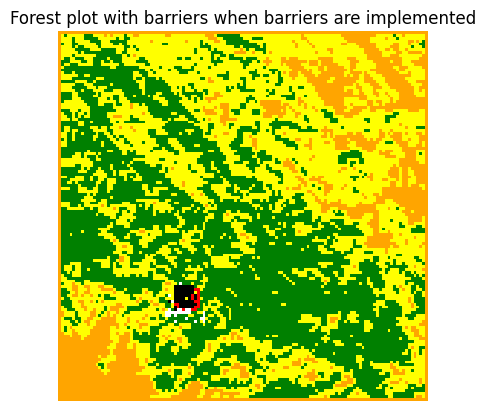

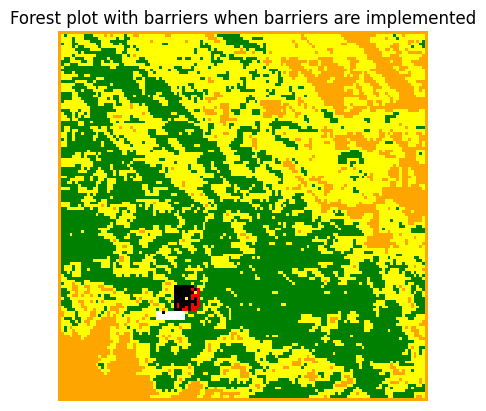

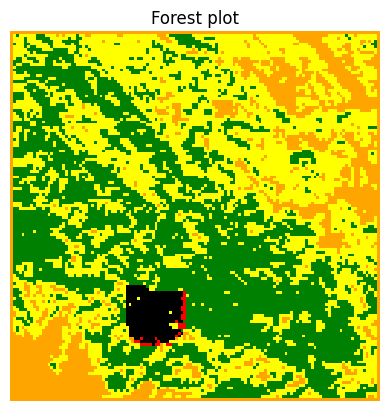

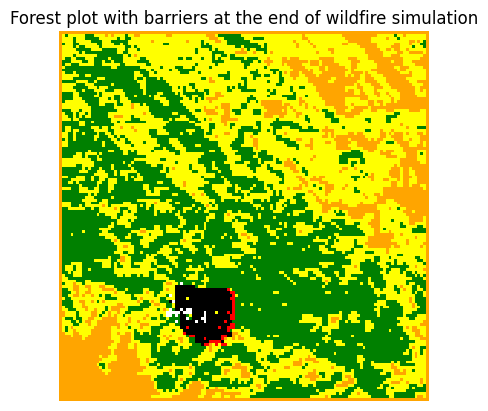

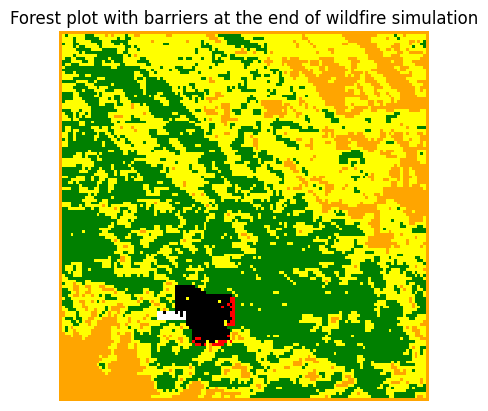

Epoch:  0  completed
Epoch:  1  completed
Epoch:  2  completed
Epoch:  3  completed
Epoch:  4  completed
Epoch:  5  completed
Epoch:  6  completed
Epoch:  7  completed
Epoch:  8  completed
Epoch:  9  completed
Epoch:  10  completed
Epoch:  11  completed
Epoch:  12  completed
Epoch:  13  completed
Epoch:  14  completed
Epoch:  15  completed
Epoch:  16  completed
Epoch:  17  completed
Epoch:  18  completed
Epoch:  19  completed
Epoch:  20  completed
Epoch:  21  completed
Epoch:  22  completed
Epoch:  23  completed
Epoch:  24  completed


ZeroDivisionError: ignored

In [16]:

import gc #to clear RAM
import glob #to clear folders
import os

#Defining constants over training
bar_length = 30
num_epochs = 750
num_simulations = 1
Network = DQN(2, [16,16], summary = True) #action space of 2, input image shape of (16,16,1) for each neighbour cell
burnt_diff = []
emp_burnt_area = []
bar_burnt_area = []
rand_burnt_area = []
buffer_index = 0
loss_values = []
lr = []



#to plot the forest at every 50 epochs
def plot_forest(forest_array, bar = False, start = False):
  cmap = mpl.colors.ListedColormap(['orange', 'yellow', 'green', 'red', 'black', 'white', 'blue'])
  cmap.set_over('0.25')
  cmap.set_under('0.75')
  bounds = [1.0, 2.02, 2.27, 3.01, 3.5, 5.1, 5.9, 6.9]
  norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
  vegetation_matrix = forest
  plt.imshow(forest + forest_array,  cmap = cmap, norm = norm, interpolation="none" )
  plt.axis('off')
  if bar == False:
    plt.title("Forest plot")
  if bar == True and start == False:
    plt.title("Forest plot with barriers at the end of wildfire simulation")
  elif bar == True and start == True:
    plt.title("Forest plot with barriers when barriers are implemented")

  #plt.savefig(directory + 'fire_' + str(day).zfill(3) +'.png', format='png',bbox_inches='tight')

  plt.show()
  plt.close()




for epoch in range(num_epochs):
  for sim in range(num_simulations):
    #computing a new simulated fire (ignition is from the centre of the forest every time)
    current_forest, alt, wind = simulation(1, 3, 3, False)
    Network.burning_cells(current_forest, wind) #find the burning cells in each case
    Network.choose_actions(current_forest, alt, wind, bar_length)
    #Network.manage_buffer_file() #makes sure only files in empty directory can be accessed
    next_state, burnt_area_diff = Network.calc_reward(current_forest)
    done = True
    #store memory
    for i in range(len(Network.bar_reward)):
      Network.store_episode(Network.bar_input_states[i], 0, Network.bar_reward[i],
                            next_state, Network.bar_Q_val[i], done) #as an action of 0 means place barrier
    for i in range(len(Network.emp_reward)):
      Network.store_episode(Network.emp_input_states_used[i], 1, Network.emp_reward[i],
                            next_state, Network.emp_Q_val_used[i], done)
    Network.bar_Q_val = None
    Network.emp_Q_val = None
    Network.bar_input_states = None
    Network.emp_input_states = None #reducing RAM
    #once theres been num_simulations simulations, update network
    if sim == (num_simulations-1):
      Network.update_explor_prob()
      #record learning rate (loss recorded within train method)
      Network.train()
      #Network.cyclic_lr(0.00001,0.07, epoch) #exponetial factor is 0.02

      #clear Bar Forests and Emp Forests directories
      os.chdir("/content/drive/MyDrive/ML/Bar Forests")
      for f in os.listdir():
        os.remove(f)
      os.chdir("/content/drive/MyDrive/ML/Emp Forests")
      for f in os.listdir():
        os.remove(f)



    if epoch == (num_epochs-1):
      emp_burnt, bar_burnt, rand_burnt, emp_state, bar_state, rand_state, initial_DQN, initial_rand = Network.evaluate_net(current_forest, alt, wind)
      Network.input_forest = None #to reduce memory
      burnt_diff.append(bar_burnt_area - emp_burnt)
      emp_burnt_area.append(emp_burnt)
      bar_burnt_area.append(bar_burnt)
      rand_burnt_area.append(rand_burnt)
      plot_forest(initial_DQN, True, True)
      plot_forest(initial_rand, True, True)
      plot_forest(emp_state)
      plot_forest(bar_state, True)
      plot_forest(rand_state, True)
      del bar_state
      del emp_state
      del emp_burnt
      del rand_state
      del bar_burnt
      del rand_burnt
      gc.collect()

    if epoch%10 == 0: #Evaluates the DQN after every 10th training
      burning_cells = False
      emp_burnt, bar_burnt, rand_burnt, emp_state, bar_state, rand_state, initial_DQN, initial_rand\
       = Network.evaluate_net(current_forest, alt, wind, rand = True)
      Network.input_forest = None #to reduce memory

      #To plot different burnt areas
      burnt_diff.append(emp_burnt - bar_burnt)
      emp_burnt_area.append(emp_burnt)
      bar_burnt_area.append(bar_burnt)
      rand_burnt_area.append(rand_burnt)

      #Plotting forests
      print("DQN placement placed at timestep 4")
      plot_forest(initial_DQN, True, True)
      print("Random placement placed at timestep 4"
      plot_forest(initial_rand, True, True)
      print("Burnt area when no barrier used")
      plot_forest(emp_state)
      print("Burnt area when DQN barrier used")
      plot_forest(bar_state, True)
      print("Burnt area when randomly placed barrier used")
      plot_forest(rand_state, True)

      #To check whether to stop early or not - stop early if no burning cells
      for row in bar_state:
        for num in row:
          if num == 3:
            burning_cells = True
      if burning_cells:
        pass
      else: #if there are no burning cells after evaluating - break out of the training process
        break

      #clearning memory
      del bar_state
      del emp_state
      del emp_burnt
      del rand_state
      del bar_burnt
      del rand_burnt
      gc.collect()

    if epoch == 220:
      emp_burnt, bar_burnt, rand_burnt, emp_state, bar_state, rand_state = Network.evaluate_net(current_forest, alt, wind)
      Network.input_forest = None #to reduce memory
      burnt_diff.append(bar_burnt_area - emp_burnt)
      emp_burnt_area.append(emp_burnt)
      bar_burnt_area.append(bar_burnt)
      rand_burnt_area.append(rand_burnt)
      plot_forest(emp_state)
      plot_forest(bar_state, True)
      plot_forest(rand_state, True)
      del bar_state
      del emp_state
      del emp_burnt
      del rand_state
      del bar_burnt
      del rand_burnt
      gc.collect()

    #clearing RAM
    del next_state
    del current_forest
    del burnt_area_diff
    del alt
    del wind
    gc.collect()

  print('Epoch: ',epoch,' completed')





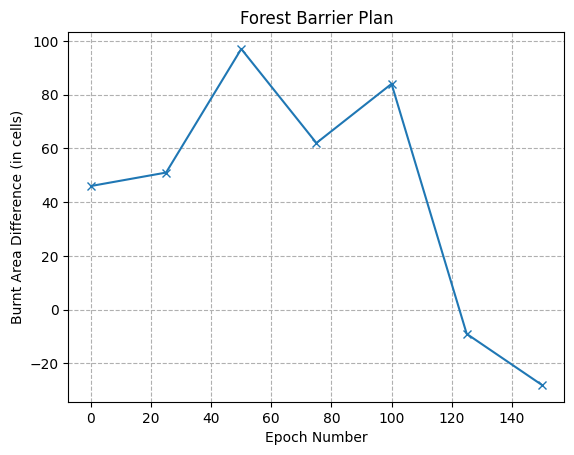

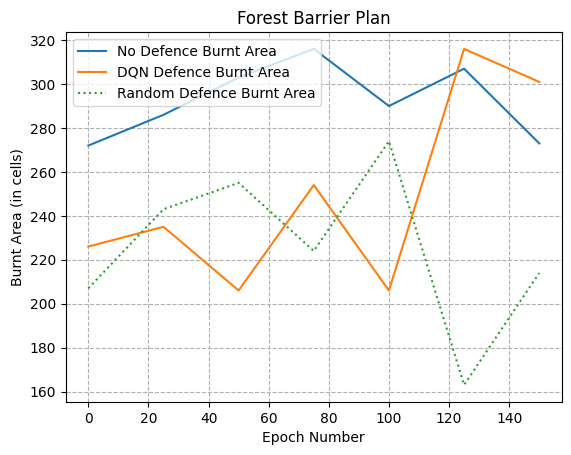

[]
[]
['emp_input_forest 0.npy', 'emp_input_forest 3.npy', 'emp_input_forest 5.npy', 'emp_input_forest 8.npy', 'emp_input_forest 9.npy', 'emp_input_forest 11.npy', 'emp_input_forest 14.npy', 'emp_input_forest 15.npy', 'emp_input_forest 17.npy', 'emp_input_forest 18.npy', 'emp_input_forest 19.npy', 'emp_input_forest 21.npy', 'emp_input_forest 22.npy', 'emp_input_forest 23.npy', 'emp_input_forest 24.npy', 'emp_input_forest 25.npy', 'emp_input_forest 26.npy', 'emp_input_forest 27.npy', 'emp_input_forest 28.npy', 'emp_input_forest 29.npy', 'emp_input_forest 30.npy', 'emp_input_forest 31.npy', 'emp_input_forest 32.npy', 'emp_input_forest 33.npy', 'emp_input_forest 35.npy', 'emp_input_forest 36.npy', 'emp_input_forest 38.npy', 'emp_input_forest 39.npy', 'emp_input_forest 40.npy', 'emp_input_forest 41.npy', 'emp_input_forest 42.npy', 'emp_input_forest 43.npy', 'emp_input_forest 44.npy', 'emp_input_forest 45.npy', 'emp_input_forest 47.npy', 'emp_input_forest 48.npy', 'emp_input_forest 49.npy',

In [17]:
##Num Epoch: 500, batch size: 64, learning rate: 0.001, exploration decay: 0.01
#avg_burntcell_diff5 = avg_burntcell_diff
import matplotlib.pyplot as plt
import numpy as np

x_axis = [0,25,50,75,100,125,150]
plt.plot(x_axis, burnt_diff, marker = 'x')
plt.ylabel("Burnt Area Difference (in cells)")
plt.xlabel("Epoch Number")
plt.title("Forest Barrier Plan")
plt.grid(linestyle = 'dashed')
plt.show()
plt.close()

x_axis = [0,25,50,75,100,125,150]
plt.plot(x_axis, emp_burnt_area, linestyle = '-', label = "No Defence Burnt Area")
plt.plot(x_axis, bar_burnt_area, label = "DQN Defence Burnt Area")
plt.plot(x_axis, rand_burnt_area, linestyle = 'dotted', label = "Random Defence Burnt Area")
plt.ylabel("Burnt Area (in cells)")
plt.xlabel("Epoch Number")
plt.title("Forest Barrier Plan")
plt.grid(linestyle = 'dashed')
plt.legend(loc = 'upper left')
plt.show()
plt.close()

#to clear Bar Forests and Emp forests folders
import os
import cv2
import glob
import numpy as np
os.chdir("/content")
os.chdir("/content/drive/MyDrive/ML/Bar Forests")
print(os.listdir())
for f in os.listdir():
  os.remove(f)
print(os.listdir())
os.chdir("/content/drive/MyDrive/ML/Emp Forests")
print(os.listdir())
for f in os.listdir():
  os.remove(f)
print(os.listdir())
os.chdir("/content/drive/MyDrive/ML/Buffer Forests")
print(os.listdir())
for f in os.listdir():
  os.remove(f)
print(os.listdir())

## Testing performance

In [ ]:
#Examining Learning Rates
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
av_loss_val = []
window = 5
for ind in range(len(loss_values) - window + 1): #creating moving average
  av_loss_val.append(np.mean(loss_values[ind:ind+window]))
for ind in range(window - 1): #getting the correct shape
  av_loss_val.insert(0, np.nan)

ax1.plot(lr, loss_values)
ax1.set_xlabel('Learning rate')
ax1.set_ylabel('Loss')
ax1.set_title('Loss vs Learning Rate')
ax1.set_xscale('log')
plt.show()
plt.close()
fig = plt.figure()
ax2 = fig.add_subplot(1,1,1)
ax2.plot(lr, av_loss_val)
ax2.set_xlabel('Average Learning Rate')
ax2.set_ylabel('Loss')
ax2.set_title('Loss vs Learning Rate')
ax2.set_xscale('log')
plt.xlim(0.0002, 0.001)
plt.show()
plt.close()

In [1]:
#to clear Bar Forests and Emp forests and buffer forests folders
import os
import cv2
import glob
import numpy as np
os.chdir("/content")
os.chdir("/content/drive/MyDrive/ML/Bar Forests")
print(os.listdir())
for f in os.listdir():
  os.remove(f)
print(os.listdir())
os.chdir("/content/drive/MyDrive/ML/Emp Forests")
print(os.listdir())
for f in os.listdir():
  os.remove(f)
print(os.listdir())
os.chdir("/content/drive/MyDrive/ML/Buffer Forests")
print(os.listdir())
for f in os.listdir():
  os.remove(f)
print(os.listdir())


FileNotFoundError: ignored

In [ ]:
#print(Network.bar_cells)
#print(Network._best_cells)
print(Network.wind_matrix)

0


In [ ]:
print(buffer_index)

790


In [ ]:
print(len(os.listdir(buffer_directory)))
print(len([memory["current_state"] for memory in Network.memory_buffer]))
file = ['blah ba 0.npy', 'wohdogh 6.npy', '16.npy', 'aphgljha 10.npy', 'gjwoeir 112.npy', 'alhg0oh 1.npy']
for item in file:
  if str(501%500)+".npy" in item:
    print(item)


498
500
alhg0oh 1.npy


In [ ]:
Network.burning_cell

AttributeError: ignored